# **BioPred Phase 1 Feature Engineering**

In this portion of the project, we will look to:

1. Take our notebook from our EDA phase and edit it, creating new features using the power of RDKit.

2. Encode our canonical_smiles feature using Morgan Fingerprints so they are able to be read as numerical, and so we can then use them in our models.

3. Take our categorical features and encode them separately, using One-Hot or similar so they are represented appropriately in the dataframe.

#### First as we have done in other notebooks let's import our libraries and read in our current eda_df file, saving it to another variable so we can work on it without deviating from the original data file still in progress.

In [1]:
# List libraries needed for this notebook.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from rdkit import Chem, DataStructs
from rdkit.Chem import Descriptors, GraphDescriptors, AllChem
from rdkit.Chem.rdFingerprintGenerator import GetMorganGenerator
from rdkit.DataStructs import BitVectToText
from sklearn.neighbors import KDTree
from sklearn.feature_selection import RFECV
from xgboost import XGBRegressor
from sklearn.model_selection import KFold
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline
import itertools

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [2]:
# Establish file path to read in eda_df for usage here.
file_path = "/home/azureuser/cloudfiles/code/Users/kalpha1865/BioPred/Data/df_files/eda_1_phase_1.parquet"
fe_df = pd.read_parquet(file_path)

print(fe_df.shape)
fe_df.head()

(343659, 13)


,canonical_smiles,full_mwt,alogp,psa,hba_lipinski,hbd_lipinski,aromatic_rings,heavy_atoms,rtb,molecular_species,min_standard_value,activity_count,tid
0,O=C1O/C(=C/Br)CCC1c1cccc2ccccc12,317.18,4.50,26.30,2,0,2,19,1,NEUTRAL,4.615121,1.098612,11934
1,O=C1O/C(=C/I)CCC1c1cccc2ccccc12,364.18,4.54,26.30,2,0,2,19,1,NEUTRAL,3.433987,0.693147,11934
2,C#C/C=C1\CCC(c2cccc3ccccc23)C(=O)O1,262.31,3.78,26.30,2,0,2,20,1,NEUTRAL,4.564348,0.693147,11934
3,COc1cc2nc(N3CCN(C(=O)C4CC4c4ccccc4)CC3)nc(N)c2...,433.51,2.68,93.81,8,2,3,32,5,NEUTRAL,0.412110,0.693147,104304
4,COc1cc2nc(N3CCN(S(=O)(=O)c4cccs4)CC3)nc(N)c2cc1OC,435.53,1.80,110.88,9,2,3,29,5,NEUTRAL,3.551914,0.693147,104304


#### So we will now look to expand our features using RDKit.  It comes with some built-in features we can use with our canonical_smiles data to enhance our dataset, providing new looks into our data.  We will then go back to our EDA ntbk with this and examine how this effects our data and our target. 

#### A lot of the features we already have in our current dataframe were provided by RDKit originally, so it is a matter of obtaining ones to be complementary to our goals.  Let's take a look at some of the features that can be added:

**Molecular Complexity (BertzCT, BalabanJ)**:
Complexity often correlates with unique molecular interactions.

**Shape Descriptors (FractionCSP3, Kappa Indices)**:
Shape and symmetry are linked to drug-likeness.

**Surface Area (LabuteASA)**:
Surface area impacts molecular accessbility to biological targets.

**HallKierAlpha**:
Measures molecular branching, often correlating with structural diversity and bioactivity.

**PEOE_VSA**:
Key for understanding electrostatic interactions.

**Kappa1, Kappa2, Kappa3**:
Quantify molecular shape and symmetry.

**ChiX indices (Chi0, Chi1)**:
Molecular connectivity indices for structural diversity.


#### Ok now let's write the function that uses our canonical_smiles feature and calculates the new features that we want to use from the RDKit library.

In [3]:
def rdkit_features(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return {}
    return {
        "bertz_ct" : GraphDescriptors.BertzCT(mol),
        "balaban_j" : Descriptors.BalabanJ(mol),
        "tpsa" : Descriptors.TPSA(mol),
        "fraction_csp3" : Descriptors.FractionCSP3(mol),
        "num_rings" : Descriptors.RingCount(mol),
        "labute_asa" : Descriptors.LabuteASA(mol),
        "molecular_volume" : Descriptors.MolMR(mol)
    }

# Now apply to our dataset.
fe_df['rdkit_feats'] = fe_df['canonical_smiles'].apply(rdkit_features)
rdkit_feats_df = pd.DataFrame(fe_df['rdkit_feats'].tolist())
fe_df = pd.concat([fe_df, rdkit_feats_df], axis = 1)
fe_df.drop(columns = ['rdkit_feats'], inplace = True)

fe_df.head()

,canonical_smiles,full_mwt,alogp,psa,hba_lipinski,hbd_lipinski,aromatic_rings,heavy_atoms,rtb,molecular_species,...,balaban_j,fraction_csp3,labute_asa,peoe_vsa1,peoe_vsa2,kappa1,kappa2,kappa3,chi0,chi1
0,O=C1O/C(=C/Br)CCC1c1cccc2ccccc12,317.18,4.50,26.30,2,0,2,19,1,NEUTRAL,...,2.032678,0.187500,119.749901,4.736863,4.794537,12.425157,5.174545,2.302843,13.242276,9.292025
1,O=C1O/C(=C/I)CCC1c1cccc2ccccc12,364.18,4.54,26.30,2,0,2,19,1,NEUTRAL,...,2.032678,0.187500,125.144192,4.736863,4.794537,12.662582,5.327835,2.388698,13.242276,9.292025
2,C#C/C=C1\CCC(c2cccc3ccccc23)C(=O)O1,262.31,3.78,26.30,2,0,2,20,1,NEUTRAL,...,1.988982,0.166667,117.611463,4.736863,4.794537,12.501099,5.223444,2.188684,13.949383,9.792025
3,COc1cc2nc(N3CCN(C(=O)C4CC4c4ccccc4)CC3)nc(N)c2...,433.51,2.68,93.81,8,2,3,32,5,NEUTRAL,...,1.273158,0.375000,186.495387,25.007213,4.794537,20.358115,8.180995,3.656405,22.241912,15.584050
4,COc1cc2nc(N3CCN(S(=O)(=O)c4cccs4)CC3)nc(N)c2cc1OC,435.53,1.80,110.88,9,2,3,29,5,NEUTRAL,...,1.582585,0.333333,172.281067,20.107303,0.000000,19.676288,7.653369,3.561938,20.595647,13.934220


#### Great now before we analyze our new data and format it let's encode our SMILES strings into Morgan fingerprints.  For reference, this converts the canonical_smiles strings into machine-readable (read numerical) format for modeling.

In [4]:
# function to encode the morgan fingerprints, return empty array for invalid smiles data.

# Initialize the Morgan Generator
morgan_gen = GetMorganGenerator(radius = 2, fpSize = 2048) # for radius and bit size

def encode_smiles_to_prints(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None # Return None instead of an empty list
    return morgan_gen.GetFingerprint(mol) # Keep as RDKit fingerprint

# Similar process now for how we just did for the feature creation.
fe_df['morgan_fingerprints'] = fe_df['canonical_smiles'].apply(encode_smiles_to_prints)

# Check type to confirm
print(type(fe_df['morgan_fingerprints'].iloc[0]))

fe_df.head()

<class 'rdkit.DataStructs.cDataStructs.ExplicitBitVect'>


,canonical_smiles,full_mwt,alogp,psa,hba_lipinski,hbd_lipinski,aromatic_rings,heavy_atoms,rtb,molecular_species,...,fraction_csp3,labute_asa,peoe_vsa1,peoe_vsa2,kappa1,kappa2,kappa3,chi0,chi1,morgan_fingerprints
0,O=C1O/C(=C/Br)CCC1c1cccc2ccccc12,317.18,4.50,26.30,2,0,2,19,1,NEUTRAL,...,0.187500,119.749901,4.736863,4.794537,12.425157,5.174545,2.302843,13.242276,9.292025,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,O=C1O/C(=C/I)CCC1c1cccc2ccccc12,364.18,4.54,26.30,2,0,2,19,1,NEUTRAL,...,0.187500,125.144192,4.736863,4.794537,12.662582,5.327835,2.388698,13.242276,9.292025,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,C#C/C=C1\CCC(c2cccc3ccccc23)C(=O)O1,262.31,3.78,26.30,2,0,2,20,1,NEUTRAL,...,0.166667,117.611463,4.736863,4.794537,12.501099,5.223444,2.188684,13.949383,9.792025,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,COc1cc2nc(N3CCN(C(=O)C4CC4c4ccccc4)CC3)nc(N)c2...,433.51,2.68,93.81,8,2,3,32,5,NEUTRAL,...,0.375000,186.495387,25.007213,4.794537,20.358115,8.180995,3.656405,22.241912,15.584050,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,COc1cc2nc(N3CCN(S(=O)(=O)c4cccs4)CC3)nc(N)c2cc1OC,435.53,1.80,110.88,9,2,3,29,5,NEUTRAL,...,0.333333,172.281067,20.107303,0.000000,19.676288,7.653369,3.561938,20.595647,13.934220,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ..."


#### Now a quick step we will do is make all of our new fingerprints into NumPy arrays.

In [5]:
# Convert the morgan_fingerprints column to a NumPy array
fps = np.array(fe_df["morgan_fingerprints"].tolist())

# Check for all-zero fingerprints row-wise
num_zero_fingerprints = np.sum(np.all(fps == 0, axis=1))

print(f"Number of rows with all-zero fingerprints: {num_zero_fingerprints}")

print(type(fps[0]))


Number of rows with all-zero fingerprints: 0
<class 'numpy.ndarray'>


In [6]:
# quick check for missing values
print(fe_df["morgan_fingerprints"].isnull().sum())
print(fe_df["morgan_fingerprints"].apply(type).value_counts())


0
morgan_fingerprints
<class 'rdkit.DataStructs.cDataStructs.ExplicitBitVect'>    343659
Name: count, dtype: int64


In [11]:
fe_df['morgan_fingerprints'] = fps

#### At this point we will save our progress and create a new parquet file that we will call back in our EDA notebook, to continue our analysis.  

In [8]:
file_path = "/home/azureuser/cloudfiles/code/Users/kalpha1865/BioPred/Data/df_files/feat_eng_1_phase_1.parquet"
fe_df.to_parquet(file_path, index = False)
print("Feature engineering phase 1 data saved as Parquet in df_files in Data folder.")

Feature engineering phase 1 data saved as Parquet in df_files in Data folder.


#### We just finished preprocessing in the phase_1_eda ntbk with feature generation and filtering, adding some new features that correlate well with our target through looking at the mean.  Let's read in the current iteration of that df now.

In [9]:
file_path = "/home/azureuser/cloudfiles/code/Users/kalpha1865/BioPred/Data/df_files/eda_2_phase_1.parquet"
feat_fil_df = pd.read_parquet(file_path)

feat_fil_df.head()

feat_fil_df.columns

Index(['canonical_smiles', 'full_mwt', 'alogp', 'psa', 'hba_lipinski',
       'hbd_lipinski', 'aromatic_rings', 'heavy_atoms', 'rtb',
       'min_standard_value', 'tid', 'bertz_ct', 'hallkier_alpha', 'balaban_j',
       'fraction_csp3', 'labute_asa', 'peoe_vsa1', 'peoe_vsa2', 'kappa1',
       'kappa2', 'kappa3', 'chi0', 'chi1', 'morgan_fingerprints',
       'tanimoto_mean', 'species_BASE', 'species_NEUTRAL',
       'species_ZWITTERION', 'tanimoto_mean_target_mean',
       'bertz_ct_target_mean', 'tid_target_mean', 'psa_target_mean',
       'full_mwt_target_mean', 'labute_asa_target_mean', 'chi0_target_mean',
       'hallkier_alpha_target_mean', 'kappa1_target_mean', 'chi1_target_mean',
       'peoe_vsa1_target_mean'],
      dtype='object')

#### In order to give us the best chance at having good predicting features for our modeling set we will look at PCA (Principal Component Analysis) as well as a few other feature creation steps before we save our final dataframe.

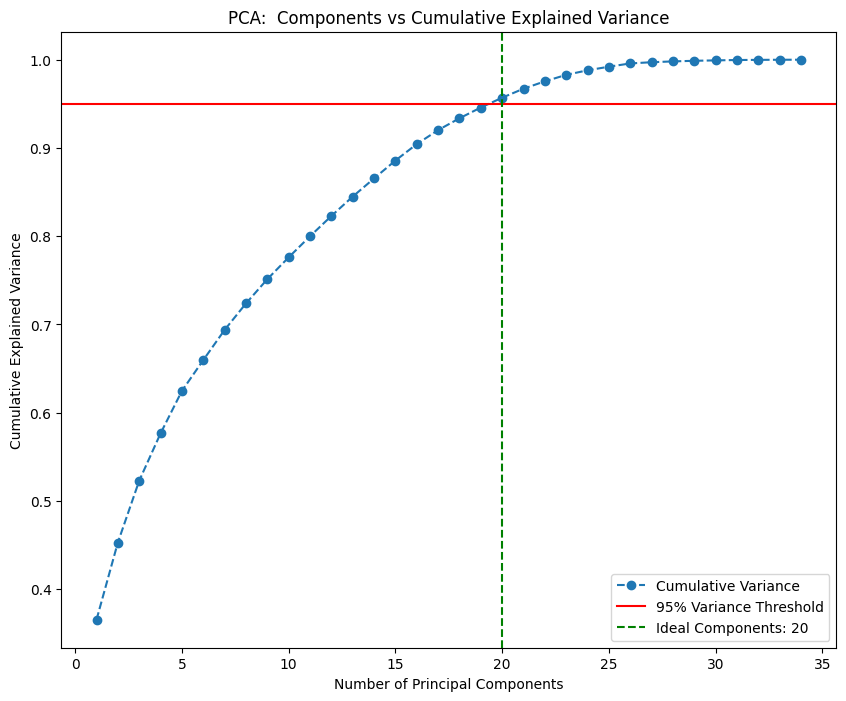

In [16]:
# Drop unnecessary columns first
exclude_cols = ['morgan_fingerprints', 'canonical_smiles', 'min_standard_value',
                'tanimoto_mean', 'tanimoto_mean_target_mean'] # Tanimoto should be removed anyway
feat_fil_numeric = feat_fil_df.drop(columns = [col for col in exclude_cols if col in feat_fil_df.columns])

# Important to scale the data first as well before performing the PCA
scaler = StandardScaler()
feat_fil_scaled = scaler.fit_transform(feat_fil_numeric)

# Initialize PCA and fit to our current dataframe
pca = PCA()
pca.fit(feat_fil_scaled)

# get the cumulative variance needed to see optimal components
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

# Determine ideal # of components
ideal_components = np.argmax(cumulative_variance >= 0.95) + 1

# plot to see 95% variance threshold for optimal number of components
plt.figure(figsize = (10,8))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker = 'o', linestyle = '--', label = 'Cumulative Variance')
plt.axhline(y = 0.95, color = 'r', linestyle = '-', label = '95% Variance Threshold')
plt.axvline(x = ideal_components, color = 'g', linestyle = '--', label = f'Ideal Components: {ideal_components}')

plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA:  Components vs Cumulative Explained Variance")
plt.legend()
plt.show()

In [18]:
# Convert the ideal_components to a dataframe and concat to our current fe_df
feat_fil_df_pca = pca.transform(feat_fil_numeric)[:, :int(ideal_components)]

pca_columns = [f'PCA_{i+1}' for i in range(int(ideal_components))]
pca_df = pd.DataFrame(feat_fil_df_pca, columns = pca_columns, index = feat_fil_df.index)

fe_df_extended = pd.concat([feat_fil_df, pca_df], axis = 1)

/anaconda/envs/azureml_py38/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


#### We will now look into feature filtering, looking into a method called RFECV (Recursive Feature Elimination with Cross Validation). We will use a focused set of features that through this filtering method we can see will help us before we go into our modeling stage so that it increases our metric output even further.

#### As we go through the RFECV method, we will look at Feature Importances, and filter out the features that aren't as important for our pending modeling dataframe.

In [27]:
# Set up our X,y for target variables from our current dataframe
X = fe_df_extended.drop(columns = ['min_standard_value', 'canonical_smiles', 'morgan_fingerprints',
                                'tanimoto_mean', 'tanimoto_mean_target_mean']) # Drop everything but our target
y = fe_df_extended['min_standard_value']

# Define and set up a base model to use RFECV
model_xgb = XGBRegressor(
    n_estimators = 300,
    learning_rate = 0.05,
    max_depth = 7,
    min_child_weight = 5,
    random_state = 42,
    n_jobs=-1)

cv = KFold(n_splits=5, shuffle=True, random_state=42)
rfecv_xgb = RFECV(estimator=model_xgb, step = 0.1, scoring = 'neg_mean_squared_error', cv = cv)

# Fit the RFECV
rfecv_xgb.fit(X,y)

# Extract the features
selected_features_xgb = X.columns[rfecv_xgb.support_]
print(f"Optimal number of features: {rfecv_xgb.n_features_}")
print(f"Selected features: {list(selected_features_xgb)}")

# Plot RFECV results
plt.figure(figsize = (10,8))
plt.xlabel("Number of features selected")
plt.ylabel("Cross-validation score (negative MSE)")
plt.title("RFECV - Feature Selection")
plt.plot(range(1, len(rfecv_xgb.cv_results_['mean_test_score']) + 1), rfecv_xgb.cv_results_['mean_test_score'])
plt.show()

KeyboardInterrupt: 

In [ ]:
#Retrain the model again with the selected features without the CV
X_selected = X[selected_features_xgb].copy()
X_selected = X_selected.reset_index(drop = True)

final_xgb = XGBRegressor(
    n_estimators=300,  
    learning_rate=0.05,
    max_depth=7,
    min_child_weight=5,
    random_state=42,
    n_jobs=-1
)

final_xgb.fit(X_selected, y)

# Now get feature importances from this second model
importances = final_xgb.feature_importances_

# Sort feature importances
sorted_idx = np.argsort(importances)[::-1] # Sort in descending order

# Step 3: Plot Feature Importances from the FINAL trained model
plt.figure(figsize=(10, 6))
plt.barh(X_selected.columns[sorted_idx][:20], importances[sorted_idx][:20], color = 'teal')
plt.xlabel("Feature Importances")
plt.ylabel("Feature")
plt.title("RFECV Feature Importance")
plt.gca().invert_yaxis()
plt.show()

#### The above plot does a good job of showing that we have a handful of good predicting features, with a scattering of minor ones.  I want to do one more feature creation step and then run our RFECV once more before we go into modeling.

#### I want to take our more popular features shown above and combine them together to see if we can get any new important features from them.  We will just use the top 10, and for each combination we will use multiplication and division on each to get new features.  We will then add these to our current feature list before running our RFECV one more time before modeling.

In [ ]:
# Make new list of features based on our first RFECV run.
feat_set = []

# Generate all pairwise combinations
feature_combinations = list(itertools.combinations(feat_set, 2))

# Generate new columns for our operations (multiplication and division)
for f1, f2 in feature_combinations:
    fe_df_extended[f"{f1}_x_{f2}"] = fe_df_extended[f1] * fe_df_extended[f2]
    fe_df_extended[f"{f1}_div_{f2}"] = fe_df_extended[f1] / (fe_df_extended[f2] + 1e-8) # Avoid division by zero
    
print(fe_df_extended.shape)

#### Great all of those new features are added to our current dataframe.  Let's run our RFECV one more time, this time looking at just the top 15 features.

In [ ]:
# Set up our X,y for target variables from our current dataframe
X = fe_df_extended.drop(columns = ['min_standard_value', 'canonical_smiles', 'morgan_fingerprints',
                                'tanimoto_mean', 'tanimoto_mean_target_mean']) # Drop everything but our target
y = fe_df_extended['min_standard_value']

# Define and set up a base model to use RFECV
model_xgb = XGBRegressor(
    n_estimators = 300,
    learning_rate = 0.05,
    max_depth = 7,
    min_child_weight = 5,
    random_state = 42,
    n_jobs=-1)

cv = KFold(n_splits=5, shuffle=True, random_state=42)
rfecv_xgb = RFECV(estimator=model_xgb, step = 0.2, scoring = 'neg_mean_squared_error', cv = cv) # Step param at 0.2 to be more restrictive since we have a lot more features to filter

# Fit the RFECV
rfecv_xgb.fit(X,y)

# Extract the features
selected_features_xgb = X.columns[rfecv_xgb.support_]
print(f"Optimal number of features: {rfecv_xgb.n_features_}")
print(f"Selected features: {list(selected_features_xgb)}")

# Plot RFECV results
plt.figure(figsize = (10,8))
plt.xlabel("Number of features selected")
plt.ylabel("Cross-validation score (negative MSE)")
plt.title("RFECV - Feature Selection")
plt.plot(range(1, len(rfecv_xgb.cv_results_['mean_test_score']) + 1), rfecv_xgb.cv_results_['mean_test_score'])
plt.show()

In [ ]:
#Retrain the model again with the selected features without the CV
X_selected = X[selected_features_xgb].copy()
X_selected = X_selected.reset_index(drop = True)

X_selected_np = X_selected.to_numpy()

final_xgb = XGBRegressor(
    n_estimators=300,  
    learning_rate=0.05,
    max_depth=7,
    min_child_weight=5,
    random_state=42,
    n_jobs=-1
)

final_xgb.fit(X_selected_np, y)

# Now get feature importances from this second model
importances = final_xgb.feature_importances_
feature_names = X_selected.columns

# make a quick dataframe and sort by importance
importance_df = pd.DataFrame({'Feature' : feature_names, 'Importance' : importances})
importance_df = importance_df.sort_values(by = 'Importance', ascending = False)[:20]

# Step 3: Plot Feature Importances from the FINAL trained model
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color = 'orange')
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("XGBoost Feature Importance (Top 15 Features)")
plt.gca().invert_yaxis()
plt.show()

In [ ]:
# Save the top features to a new df, remembering to add back in the ones we dropped earlier.
ph1_df = fe_df_extended[['morgan_fingerprints', 'chi1_target_mean', 'min_standard_value',
                'bertz_ct_target_mean', 'tid_target_mean', 'psa_target_mean',
                'full_mwt_target_mean', 'labute_asa_target_mean', 'hba_lipinski',
                'aromatic_rings', 'hallkier_alpha', 'peoe_vsa1_target_mean'
                ]]

file_path = "/home/azureuser/cloudfiles/code/Users/kalpha1865/BioPred/Data/df_files/modeling_phase_1.parquet"
ph1_df.to_parquet(file_path, index = False)
print("Modeling phase 1 data saved as Parquet in df_files in Data folder.")

In [ ]:
print(ph1_df.head())
print(ph1_df.shape)